In [ ]:
# !pip install -U ultralytics

In [ ]:
import cv2
from ultralytics import YOLO
from datetime import datetime, timedelta
import pandas as pd
from typing import List, Dict

In [30]:
# Define the horizontal and perpendicular line positions
line_position_horizontal = 800
line_position_perpendicular = 1020
frame_width = 1920
frame_height = 1080

START_POINT_HORIZONTAL = (0, line_position_horizontal)
END_POINT_HORIZONTAL = (frame_width, line_position_horizontal)
START_POINT_PERPENDICULAR = (line_position_perpendicular, 440)
END_POINT_PERPENDICULAR = (1110, frame_height)

In [31]:
def initialize_video_writer(export_path: str, frame_width: int, frame_height: int) -> cv2.VideoWriter:
    """
    Initialize the video writer.
    """
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    frame_rate = 30  # Assuming 30 FPS for the video
    return cv2.VideoWriter(export_path, fourcc, frame_rate, (frame_width, frame_height))

def update_car_count_and_record_state(track_id: int, direction: str, car_counts: dict, already_counted: dict, current_time: datetime, state_changes: list):
    """
    Update the car count for the specified direction if the car hasn't been counted in that direction yet and record the state change.
    """
    if track_id not in already_counted or already_counted[track_id] != direction:
        car_counts[direction] += 1
        already_counted[track_id] = direction
        # Record the state change with a precise timestamp
        state_changes.append({'car_id': track_id, 'timestamp': current_time.strftime("%Y-%m-%d %H:%M:%S.%f"), 'state': direction})

In [26]:
def inference(model: YOLO, video_path: str, export_path: str, device: str = 'cpu', imgsz=(640,640)) -> List[Dict]:
    """
    Run inference on the video and export the annotated video. Returns the state changes.
    """
    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    out = initialize_video_writer(export_path, frame_width, frame_height)

    # Initialize simulation variables
    start_time = datetime.strptime("19.02.2024 13:50:00", "%d.%m.%Y %H:%M:%S")  # Simulated start time
    frame_rate = 30  # Assuming 30 FPS for the video
    time_per_frame = timedelta(seconds=1/frame_rate)
    current_time = start_time

    # Initialize tracking variables
    car_positions = {}
    car_counts = {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
    already_counted = {}    # Tracks whether a car has been counted to prevent double counting
    state_changes = []  # To record state changes with timestamps

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        # Draw the horizontal and perpendicular lines
        cv2.line(frame, START_POINT_HORIZONTAL, END_POINT_HORIZONTAL, (0, 255, 0), 2)
        cv2.line(frame, START_POINT_PERPENDICULAR, END_POINT_PERPENDICULAR, (255, 0, 0), 2)

        # Run YOLOv8 tracking on the frame
        results = model.track(frame, classes=[2, 7], persist=True, device=device, imgsz=imgsz)   # Focusing on cars (class 2) and trucks (class 7)

        # Get the boxes and track IDs
        boxes = results[0].boxes.xywh.cpu()
        if results[0].boxes.id is not None:
            track_ids = results[0].boxes.id.int().cpu().tolist()

            for box, track_id in zip(boxes, track_ids):
                x, y, w, h = box
                center = (int(x), int(y))
                bbox_color = (255, 0, 0)  # Default color

                # Determine if the car has crossed the lines and update counts
                if track_id in car_positions:
                    prev_center = car_positions[track_id]
                    # Horizontal line crossing logic
                    if prev_center[1] < line_position_horizontal <= center[1]:
                        update_car_count_and_record_state(track_id, 'DOWN', car_counts, already_counted, current_time, state_changes)
                        bbox_color = (0, 255, 0)
                    elif prev_center[1] > line_position_horizontal >= center[1]:
                        update_car_count_and_record_state(track_id, 'UP', car_counts, already_counted, current_time, state_changes)
                        bbox_color = (0, 255, 0)
                    # Perpendicular line crossing logic
                    if prev_center[0] < line_position_perpendicular <= center[0]:
                        update_car_count_and_record_state(track_id, 'RIGHT', car_counts, already_counted, current_time, state_changes)
                        bbox_color = (255, 0, 0)
                    elif prev_center[0] > line_position_perpendicular >= center[0]:
                        update_car_count_and_record_state(track_id, 'LEFT', car_counts, already_counted, current_time, state_changes)
                        bbox_color = (255, 0, 0)

                # Update the car's current position
                car_positions[track_id] = center

                # Draw bounding box and track ID
                cv2.rectangle(frame, (int(x - w / 2), int(y - h / 2)), (int(x + w / 2), int(y + h / 2)), bbox_color, 2)
                cv2.putText(frame, f"ID: {track_id}", (int(x - w / 2), int(y - h / 2) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, bbox_color, 2)

        # Display counts
        cv2.putText(frame, f"Up: {car_counts['UP']} Down: {car_counts['DOWN']}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(frame, f"Left: {car_counts['LEFT']} Right: {car_counts['RIGHT']}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        # Increment the simulated time
        current_time += time_per_frame

        # Display the simulated clock on the video
        cv2.putText(frame, current_time.strftime("%Y-%m-%d %H:%M:%S.%f")[:-3], (10, frame_height - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        # Write the frame with annotations to the output video
        out.write(frame)

    # Release the video capture and writer
    cap.release()
    out.release()

    return state_changes

In [28]:
from ultralytics import YOLO

video_path = 'video2.MOV'
model = YOLO('yolov8n.pt', verbose=True)
state_changes = inference(model, video_path, "real.mp4", device='cuda:0', imgsz=(640,640))


0: 160x256 (no detections), 156.2ms
Speed: 3.1ms preprocess, 156.2ms inference, 2.6ms postprocess per image at shape (1, 3, 160, 256)

0: 160x256 (no detections), 162.8ms
Speed: 1.3ms preprocess, 162.8ms inference, 7.2ms postprocess per image at shape (1, 3, 160, 256)

0: 160x256 (no detections), 155.7ms
Speed: 2.8ms preprocess, 155.7ms inference, 2.6ms postprocess per image at shape (1, 3, 160, 256)

0: 160x256 (no detections), 33.7ms
Speed: 3.8ms preprocess, 33.7ms inference, 2.8ms postprocess per image at shape (1, 3, 160, 256)

0: 160x256 (no detections), 29.8ms
Speed: 2.3ms preprocess, 29.8ms inference, 2.8ms postprocess per image at shape (1, 3, 160, 256)

0: 160x256 (no detections), 29.9ms
Speed: 2.2ms preprocess, 29.9ms inference, 2.6ms postprocess per image at shape (1, 3, 160, 256)

0: 160x256 (no detections), 19.1ms
Speed: 1.3ms preprocess, 19.1ms inference, 0.9ms postprocess per image at shape (1, 3, 160, 256)

0: 160x256 (no detections), 16.8ms
Speed: 0.8ms preprocess, 16

In [29]:
df = pd.DataFrame(state_changes)
df.to_csv('car_state_changes.csv', index=False)

In [5]:
from ultralytics import YOLO

# Load the YOLOv8 model
model_path = 'yolov8n.pt'  # Adjust this path to your model's location
model = YOLO(model_path)

# Export the model to ONNX format
model.export(format='onnx', dynamic=True, simplify=True)

Ultralytics YOLOv8.1.15 🚀 Python-3.10.13 torch-2.1.2 CPU (Intel Core(TM) i7-7700HQ 2.80GHz)
WARNING ⚠️ imgsz=[360, 640] must be multiple of max stride 32, updating to [384, 640]
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 384, 640) BCHW and output shape(s) (1, 84, 5040) (6.2 MB)

ONNX: starting export with onnx 1.15.0 opset 17...
ONNX: simplifying with onnxsim 0.4.35...
ONNX: export success ✅ 3.2s, saved as 'yolov8n.onnx' (12.1 MB)

Export complete (5.3s)
Results saved to /home/seekndestroy/talha/github/car-tracking-counting
Predict:         yolo predict task=detect model=yolov8n.onnx imgsz=384,640  
Validate:        yolo val task=detect model=yolov8n.onnx imgsz=384,640 data=coco.yaml  WARNING ⚠️ non-PyTorch val requires square images, 'imgsz=[384, 640]' will not work. Use export 'imgsz=640' if val is required.
Visualize:       https://netron.app


'yolov8n.onnx'

In [8]:
import time

video_path = "d.mp4"
onnx_model = YOLO('yolov8n.onnx')
pytorch_model = YOLO('yolov8n.pt')
device = "cpu"

# Prepare the video for inference and measure performance
start_time_onnx = time.time()
# Process video frames with the ONNX model
inference(onnx_model, video_path, "output_onnx.mp4", device)
# Measure inference time
end_time_onnx = time.time()

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading yolov8n.onnx for ONNX Runtime inference...

0: 640x640 7 cars, 297.2ms
Speed: 1.6ms preprocess, 297.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 cars, 225.5ms
Speed: 2.8ms preprocess, 225.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 cars, 255.7ms
Speed: 3.4ms preprocess, 255.7ms inference, 23.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 cars, 269.3ms
Speed: 24.1ms preprocess, 269.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 cars, 221.0ms
Speed: 6.3ms preprocess, 221.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 cars, 276.9ms
Speed: 3.7ms preprocess, 276.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 ca

In [9]:
# Repeat the process for the PyTorch model
start_time_pytorch = time.time()
# Process video frames with the PyTorch model
inference(pytorch_model, video_path, "output_pytorch.mp4", device)
# Measure inference time
end_time_pytorch = time.time()


0: 384x640 7 cars, 225.8ms
Speed: 1.8ms preprocess, 225.8ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 208.2ms
Speed: 2.4ms preprocess, 208.2ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 122.4ms
Speed: 2.8ms preprocess, 122.4ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 316.2ms
Speed: 4.3ms preprocess, 316.2ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 178.3ms
Speed: 3.4ms preprocess, 178.3ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 129.3ms
Speed: 3.2ms preprocess, 129.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 205.8ms
Speed: 2.3ms preprocess, 205.8ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 190.8ms
Speed: 2.4ms preprocess, 190.8ms inference, 3.5ms postprocess per image at shape (1, 3, 38

In [10]:
# Calculate and compare inference times
inference_time_onnx = end_time_onnx - start_time_onnx
inference_time_pytorch = end_time_pytorch - start_time_pytorch
print(f"ONNX Inference Time: {inference_time_onnx} seconds")
print(f"PyTorch Inference Time: {inference_time_pytorch} seconds")

ONNX Inference Time: 260.5895266532898 seconds
PyTorch Inference Time: 183.4664969444275 seconds


In [17]:
df

,car_id,timestamp,state
0,3,2024-02-18 05:50:02.531224,RIGHT
1,2,2024-02-18 05:50:02.631223,DOWN
2,3,2024-02-18 05:50:02.797888,DOWN
3,2,2024-02-18 05:50:03.231217,LEFT
4,10,2024-02-18 05:50:04.597870,LEFT
5,4,2024-02-18 05:50:04.697869,DOWN
6,10,2024-02-18 05:50:06.464518,RIGHT
7,5,2024-02-18 05:50:08.764495,DOWN
8,5,2024-02-18 05:50:09.031159,LEFT
9,10,2024-02-18 05:50:10.497811,DOWN


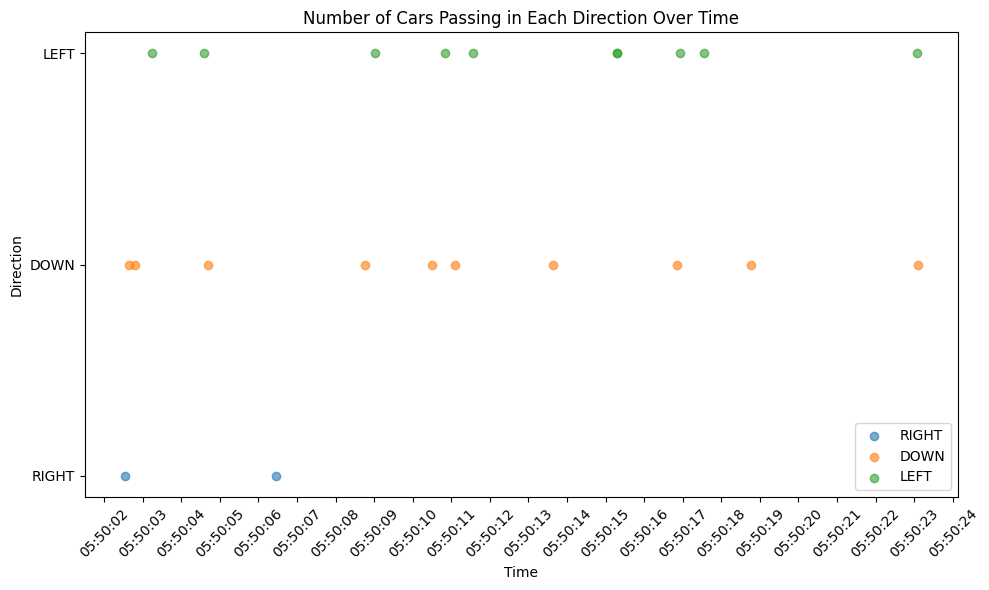

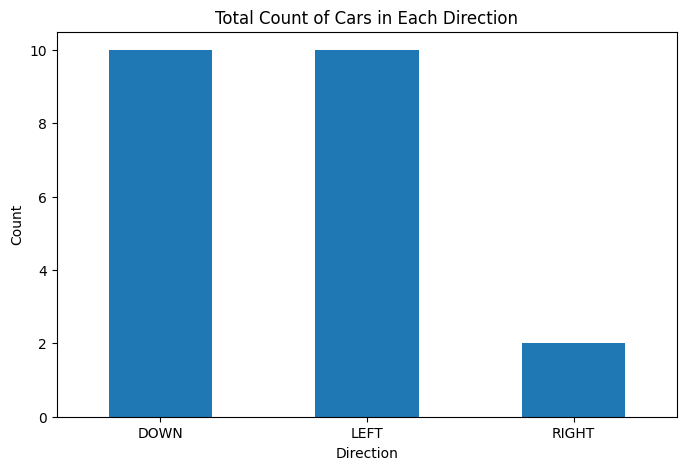

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the data
df = pd.read_csv('car_state_changes.csv')

# Convert 'timestamp' to datetime format for easier manipulation
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Visualizing the number of cars passing in each direction over time
plt.figure(figsize=(10, 6))

# Ensure the plot displays time in seconds
locator = mdates.SecondLocator()
formatter = mdates.DateFormatter('%H:%M:%S')

for direction in df['state'].unique():
    # Filter data for each direction
    direction_data = df[df['state'] == direction]
    
    # Plot each timestamp directly without resampling
    plt.scatter(direction_data['timestamp'], direction_data['state'].apply(lambda x: direction), label=direction, alpha=0.6)

plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

plt.title('Number of Cars Passing in Each Direction Over Time')
plt.xlabel('Time')
plt.ylabel('Direction')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Visualizing the total count of cars in each direction
plt.figure(figsize=(8, 5))
df['state'].value_counts().plot(kind='bar')
plt.title('Total Count of Cars in Each Direction')
plt.xlabel('Direction')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()
